In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.mixture import GaussianMixture

%matplotlib inline

In [2]:
K = 5
N_PER = 100

In [4]:
def generate_random_params(k, equal_var=True):
    HIGH = 10
    SD = 1
    params = []
    for _ in range(k):
        x = np.random.uniform(high=HIGH),
        y = np.random.uniform(high=HIGH),
        sdx = np.abs(np.random.normal(scale=SD)),
        sdy = sdx if equal_var else np.abs(np.random.normal(scale=SD))
        params.append({'x': x, 'y': y, 'sdx': sdx, 'sdy': sdy})
    return params

In [5]:
def rand_color():
    digits = list('0123455679ABCDEF')
    return '#' + ''.join(np.random.choice(digits, size=6, replace=True))

In [6]:
def make_clusters(params, n_per):
    clusters = []
    for k, p in enumerate(params):
        col = rand_color()
        df = pd.DataFrame(
            {'x': np.random.normal(p['x'], scale=p['sdx'], size=n_per),
             'y': np.random.normal(p['y'], scale=p['sdy'], size=n_per),
             'k': [k] * n_per,
             'color': col})
        clusters.append(df)
    return pd.concat(clusters)

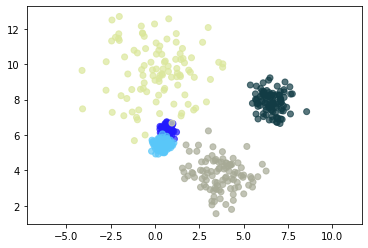

In [7]:
clust = make_clusters(generate_random_params(K), N_PER)
plt.scatter(clust.x, clust.y, color=clust.color, alpha=0.7)
plt.axis('equal');

In [8]:
clust.head()

,x,y,k,color
0,0.790755,6.420709,0,#2219FD
1,0.707473,6.295021,0,#2219FD
2,0.744911,6.131655,0,#2219FD
3,0.783622,6.297613,0,#2219FD
4,0.685432,6.125462,0,#2219FD


### Basic Usage of `sklearn.mixture.GaussianMixture`
Unlike the simple 1D case we used in R to demostrate, in higher dimensionality, we can choose increasingly complicated models by optimizing a greater number of parameters in the covariance matrix.

In [9]:
X = clust[['x', 'y']]

In [10]:
# Simplest case: single variance term for each cluster
gmm = GaussianMixture(n_components=K, covariance_type='spherical')
gmm.fit(X)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
clust['spherical_gmm'] = gmm.predict(X)

In [12]:
clust.head()

,x,y,k,color,spherical_gmm
0,0.790755,6.420709,0,#2219FD,4
1,0.707473,6.295021,0,#2219FD,4
2,0.744911,6.131655,0,#2219FD,4
3,0.783622,6.297613,0,#2219FD,4
4,0.685432,6.125462,0,#2219FD,4


In [13]:
color_map = {k: rand_color() for k in range(K)}
color_map

{0: '#B633AF', 1: '#92C750', 2: '#5A7057', 3: '#FEC231', 4: '#0A2B42'}

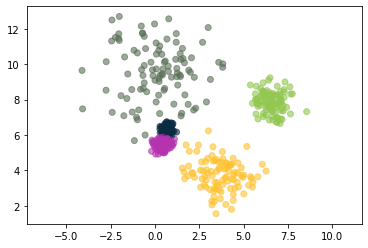

In [14]:
plt.scatter(clust.x, 
            clust.y, 
            color=clust.spherical_gmm.apply(lambda x: color_map[x]),
            alpha=0.6)
plt.axis('equal');

Another strength of the Gaussian Mixed Model is that we are not restricted to round/spherical clusters.  While `spherical` allows each component to have its own mean and a single variance/sd for all components of X, (i.e., variance must be same for x and y in example above), we can fit more parameters to allow for covariance between components.

Using `diag` allows each component to have its own variance (that is, it estimates the diagonal of the covariance matrix, but defaults other values to 0).  In other words, instead of round clusters, clusters can be elliptical.

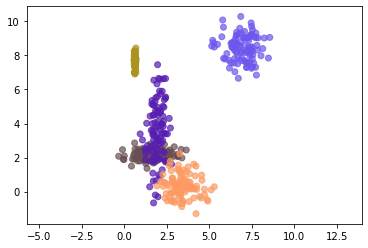

In [21]:
clust = make_clusters(generate_random_params(K, equal_var=False), N_PER)
plt.scatter(clust.x, clust.y, color=clust.color, alpha=0.7);
plt.axis('equal');

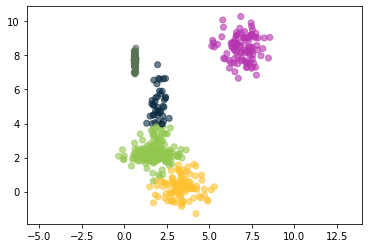

In [23]:
# Simplest case: single variance term for each cluster
X = clust[['x', 'y']]
gmm = GaussianMixture(n_components=K, covariance_type='spherical')
gmm.fit(X)
clust['spherical_gmm'] = gmm.predict(X)

plt.scatter(clust.x, 
            clust.y, 
            color=clust.spherical_gmm.apply(lambda x: color_map[x]),
            alpha=0.6)
plt.axis('equal');

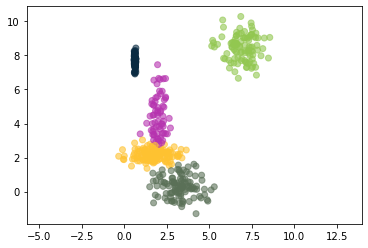

In [24]:
# diag: allows for elliptical clusters, aligned with axes
gmm = GaussianMixture(n_components=K, covariance_type='diag')
gmm.fit(X)
clust['diagonal_gmm'] = gmm.predict(X)

plt.scatter(clust.x, 
            clust.y, 
            color=clust.diagonal_gmm.apply(lambda x: color_map[x]),
            alpha=0.6)
plt.axis('equal');

And we can even have more complicated models that estimate covariances between the components (i.e., estimates the off-diagonal elements of the cov matrix as well), allowing for clusters that need not be parallel to the coordinate axes:

In [26]:
def generate_random_params(k):
    HIGH = 10
    SD = 1
    params = []
    for _ in range(k):
        x = np.random.uniform(high=HIGH)
        y = np.random.uniform(high=HIGH)
        cov = np.random.uniform(low=-HIGH / 3, high=HIGH / 3)
        sdx = np.abs(np.random.normal(scale=SD))
        sdy = np.abs(np.random.normal(scale=SD))
        sigma = [[sdx, cov],
                 [cov, sdy]]
        params.append({'x': x, 'y': y, 'sigma': sigma})
    return params

# Test
params = generate_random_params(1)[0]
params

{'x': 8.985480843732699,
 'y': 1.009167443347203,
 'sigma': [[1.4882455669602936, 1.3791469509474124],
  [1.3791469509474124, 0.5972486802927441]]}

In [27]:
np.random.multivariate_normal(
    [params['x'], params['y']], params['sigma'], size=2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


array([[ 8.39531733,  0.02797882],
       [ 5.9853323 , -1.10102547]])

In [33]:
def make_clusters(params, n_per):
    clusters = []
    for k, p in enumerate(params):
        col = rand_color()
        points = np.random.multivariate_normal(
            [p['x'], p['y']], p['sigma'], size=n_per)
        x = points[:, 0]
        y = points[:, 1]
        df = pd.DataFrame(
            {'x': x,
             'y': y,
             'k': [k] * n_per,
             'color': col})
        clusters.append(df)
    return pd.concat(clusters)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


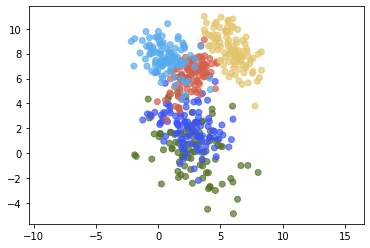

In [34]:
params = generate_random_params(K)
clust = make_clusters(params, N_PER)

plt.scatter(clust.x, clust.y, color=clust.color, alpha=0.7)
plt.axis('equal');

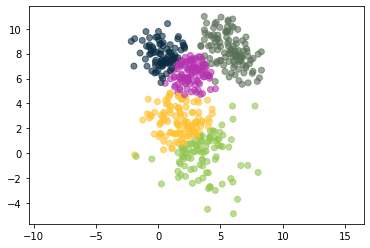

In [35]:
X = clust[['x', 'y']]

# spherical: round clusters only
gmm = GaussianMixture(n_components=K, covariance_type='spherical')
gmm.fit(X)
clust['spherical_gmm'] = gmm.predict(X)

plt.scatter(clust.x, 
            clust.y, 
            color=clust.spherical_gmm.apply(lambda x: color_map[x]),
            alpha=0.6)
plt.axis('equal');

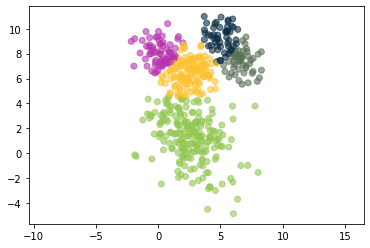

In [36]:
# diag: elliptical clusters, aligned with coordinate axes
gmm = GaussianMixture(n_components=K, covariance_type='diag')
gmm.fit(X)
clust['diagonal_gmm'] = gmm.predict(X)

plt.scatter(clust.x, 
            clust.y, 
            color=clust.diagonal_gmm.apply(lambda x: color_map[x]),
            alpha=0.6)
plt.axis('equal');

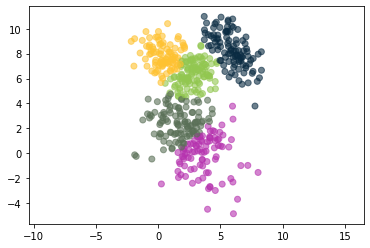

In [37]:
# full: elliptical clusters, may be rotated
gmm = GaussianMixture(n_components=K, covariance_type='full')
gmm.fit(X)
clust['full_gmm'] = gmm.predict(X)

plt.scatter(clust.x, 
            clust.y, 
            color=clust.full_gmm.apply(lambda x: color_map[x]),
            alpha=0.6)
plt.axis('equal');

There is one more, less frequently used option, `covariance_type='tied'` which will estimate a single cov matrix to be shared by all clusters, forcing them each to have the same shape and orientation.

### Question:
So far, we have assumed in advance, that we know the number of clusters.  But what if we do not know?

Visual inspection can occasionally serve well, but there will be many abiguous cases.  We will return to this in the next notebook, but think about how you might formalize this problem.... 

What if you were using K-means instead? Would your method still work?

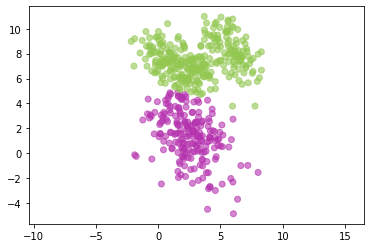

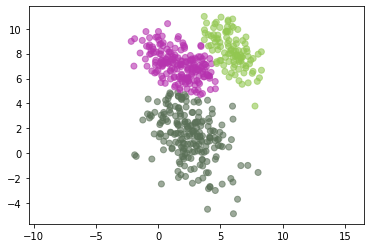

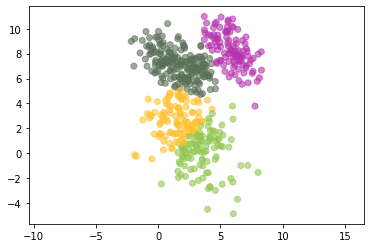

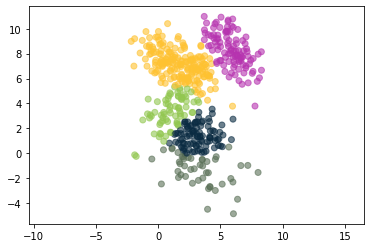

In [38]:
for k in range(2, K + 1):
    gmm = GaussianMixture(n_components=k, covariance_type='full')
    gmm.fit(X)
    assignments = gmm.predict(X)
    plt.figure()
    plt.scatter(clust.x,
                clust.y,
                color=list(map(lambda x: color_map[x], assignments)),
                alpha=0.6)
    plt.axis('equal')